**Mount the drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Load the churn data file and import packages**

In [ ]:
# import packages
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline


%cd '/content/drive/MyDrive/DS 4510/Data'
churn = pd.read_excel('churn.xlsx', sheet_name='BankChurners')

### $\color{blue}{\text{Part 1 Data Cleaning}}$

Remove everything greater than 15% missing

In [ ]:
# Function to compute missing values
def percent_missing(data):
    return data.isnull().sum().divide(len(data)).sort_values(ascending=False)

# Using the function
percent_missing(churn).head()

In [ ]:
# Numeric component of the HR dataset
churn_num = churn.select_dtypes(include=np.number)
churn_num.head()

#categorical component of the HR dataset
churn_cat = churn.select_dtypes(exclude=np.number)
churn_cat.head()

In [ ]:
# Delete ANY row with missing data
delRow_num = churn_num.dropna()

#Check if deletion worked
print(churn_num.shape)
print(delRow_num.shape)

In [ ]:
# Function to do conditional deletion

def semi_listwise(data, nan_percent):
    d1 = data.isnull().sum().divide(len(data)).sort_values(ascending=False)
    culprit_vars = []
    for i in range(len(d1.values)):
        if(d1.values[i] >= nan_percent):
            culprit_vars.append(d1.index[i])
    return data[data.columns.difference(culprit_vars)]

In [ ]:
delCol15_num = semi_listwise(churn_num, 0.15)

#Check if deletion worked
print(churn_num.shape)
print(delCol15_num.shape)

In [ ]:
#find the median first
col_med = delCol15_num.median()

#Now impute missing data with the median
no_missing = delCol15_num.fillna(col_med)

#Now check if data is missing
percent_missing(no_missing)

In [ ]:
col_mode = churn_cat.mode().stack().reset_index(level=0, drop=True)

# Impute missing data mode
no_missingCat = churn_cat.fillna(col_mode)

#Check if imputation worked
percent_missing(churn_cat)
percent_missing(no_missingCat)

In [ ]:
#combine the categorical and numerical data
full_data = pd.concat([no_missingCat, no_missing], axis=1)

In [ ]:
full_data.head()

In [ ]:
# Change "Client Attrition" column as categorical
full_data['Client_Attrition'] = full_data['Client_Attrition'].astype('category')

# Rename "Client Attrition" values of NO and YES to 0 and 1
categories = {'NO':0, 'YES':1}
full_data['Client_Attrition'] = full_data.Client_Attrition.cat.rename_categories(categories)

# convert to integer
full_data['Client_Attrition'] = full_data['Client_Attrition'].astype(int)


In [ ]:
# Delete the client attrition column
drop_vars = ['Client_Attrition']
full_data_new = full_data.drop(drop_vars, axis=1)

In [ ]:
full_data_new.head()

In [ ]:
#!pip install feature_engine
from feature_engine.encoding import MeanEncoder

mean_enc = MeanEncoder().fit(full_data_new, full_data['Client_Attrition'])

# Obtain new training and testing data with categorical variables replaced by the mean of the dependent variable
dumvars = mean_enc.transform(full_data_new)

In [ ]:
dumvars.head()

In [ ]:
#Creating a visulization for variables linearity
# !pip install dython
from dython.nominal import associations
import seaborn as sns

def corrPlot(data):

  # Use "associations" function to compute correlation between all variables
  corr_matrix = associations(dataset=data, compute_only=True)['corr']

  # Mask the upper triangle of correlation heatmap
  mask_upper = np.triu(np.ones_like(corr_matrix, dtype=bool))

  # Plotting correlation heatmap
  plt.figure(figsize=(12, 8))
  sns.heatmap(corr_matrix, annot=True, mask=mask_upper, cmap='coolwarm_r', fmt='.2f', vmin=-1, vmax=1)
  plt.show()
# Use function to plot correlation heatmap
corrPlot(data=dumvars)

**Drop highly correlated variables**

In [ ]:
'''
This function drops highly correlated variables given a threshold.
It drops the variable with smaller variance
'''

def drop_highly_correlated(data, threshold):
    cor_matrix = data.corr().abs()
    sol = (cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))).unstack().dropna()

    to_drop=[]
    for i in range(len(sol[sol > threshold].index.tolist())):
        var1 = sol[sol >= threshold].index.tolist()[i][0]
        var2 = sol[sol >= threshold].index.tolist()[i][1]

        if(data[var1].var() < data[var2].var()): to_drop.append(var1)
        else: to_drop.append(var2)

    dropped_vars = list(set(to_drop))
    return dropped_vars, data.drop(dropped_vars, axis=1)


In [ ]:
# Use the function to remove variables with high correlation
dropped_vars, churn_v2 = drop_highly_correlated(data=dumvars, threshold=0.7)

# Plot the correlation of the resulting data
corrPlot(data=churn_v2)

In [ ]:
churn_v2.head()

In [ ]:
from sklearn.feature_selection import VarianceThreshold

vThreshold = VarianceThreshold(threshold = 0.1)
vThreshold.fit_transform(churn_v2)

# Get variables with greater variance
vars = churn_v2.columns[vThreshold.get_support()]

# Subset data for variables with greater variance
churn_varDf = churn_v2[vars]

# vars # Shows us variables with good/high variance we can use
# churn_varDf # Displays updated data with relative variables

In [ ]:
from sklearn.preprocessing import StandardScaler

# Standardize data
churn_std = StandardScaler().fit_transform(churn_v2)
churn_stdDf = pd.DataFrame(churn_std, columns=churn_v2.columns)

# Bring the dependent variable to the standardized data
churn_std_full = pd.concat([churn_stdDf, full_data['Client_Attrition']], axis=1)

In [ ]:
from sklearn.model_selection import train_test_split

# Independent variables to be used in the model
dep_variable = churn_std_full['Client_Attrition']
ind_variable = churn_std_full.drop('Client_Attrition', axis=1)

# Partition data into training (70%) and testing (30%)
train_X, test_X, train_y, test_y = train_test_split(ind_variable, dep_variable, test_size=0.3, random_state=100)

In [ ]:
from sklearn.preprocessing import StandardScaler

# Standardize data (zero mean and unit variance)
scaler = StandardScaler().fit(train_X)

In [ ]:
# Group the DataFrame by Client_Attrition and calculate the mean of Total_Trans_Amt
grouped_df = churn.groupby("Client_Attrition")["Total_Trans_Amt"].mean()

# Print the results
print(grouped_df)

Client_Attrition     0    1
Income_Category            
$120K+             601  126
$40K - $60K       1519  271
$60K - $80K       1213  189
$80K - $120K      1293  242
< $40K            3874  799


TypeError: barh() missing 1 required positional argument: 'width'

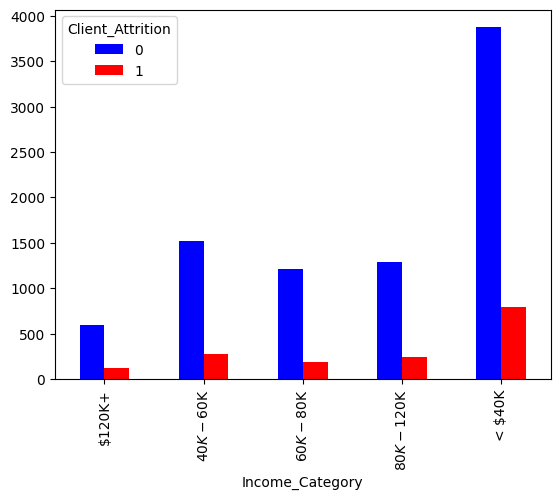

In [ ]:
import matplotlib.pyplot as plt

# Get a cross-tab for Income Category
crosstab3 = pd.crosstab(index=full_data['Income_Category'], columns=full_data['Client_Attrition'])
crosstab3

print(crosstab3)


# Plotting the cross-tabulation as a bar plot
plt.barh(crosstab3.plot(kind='bar', color=['blue', 'red']))
plt.title('Client Attrition by Income Category')
plt.xlabel('Income Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend(title='Client Attrition')
plt.show()


We believe that are clients that are below the 40k a year threshold are the most likely clients to leave our services. Therefore we want to reccommend targeting these clients for our client retention programs.

### $\color{blue}{\text{Part 2 Modeling the variables}}$

Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression


logit = LogisticRegression(random_state=0).fit(train_X, train_y)

KNN Regression

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# fit kNN model with standardized data
knn = KNeighborsClassifier(n_neighbors=3).fit(train_X, train_y)

Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# fit a random forest model
rf = RandomForestClassifier(random_state=0, max_depth=3).fit(train_X, train_y)

Support Vector Model

In [ ]:
from sklearn.svm import SVC

# Fit SVM model
svm = SVC(random_state=50).fit(train_X, train_y)

Artificial Neural Network

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=3, random_state=50, activation='logistic', solver='lbfgs', max_iter=400).fit(train_X, train_y)

Variable Importance

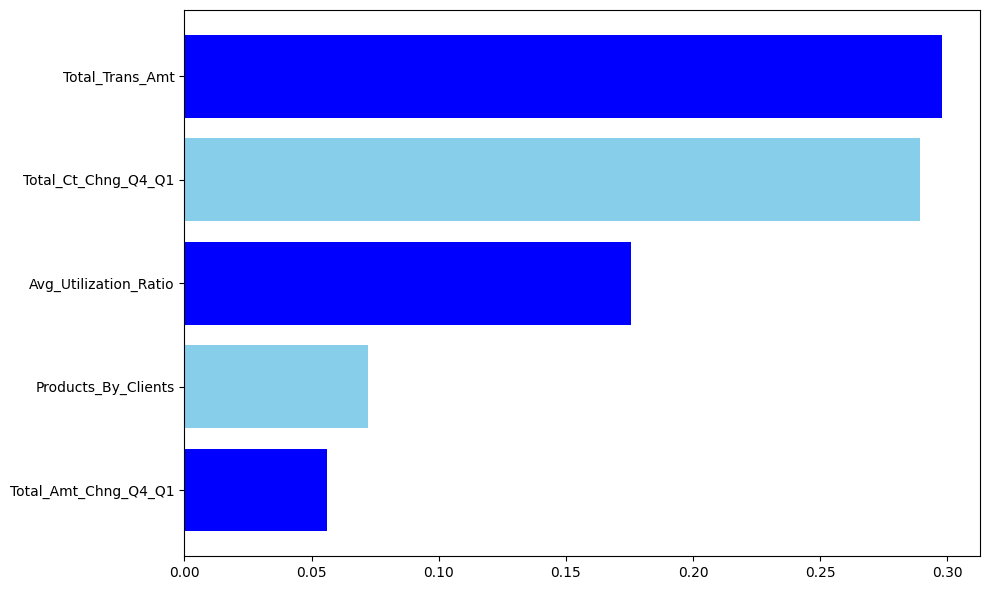

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get important variables for random forest and decision trees
rf_importances = rf.feature_importances_

# Important features
imp_rf_features = pd.DataFrame({'feature': train_X.columns, 'rf_importance': rf_importances})

# Sort variables according to their importance scores
imp_rf_features_sort = imp_rf_features.sort_values(by="rf_importance", ascending=True).tail(5)

# Plotting random forest variable importance
plt.figure(figsize=(10,6))
plt.barh(imp_rf_features_sort['feature'], imp_rf_features_sort['rf_importance'], color=['blue', 'skyblue'])
plt.title("")
plt.ylabel("")
plt.tight_layout()
plt.show()

In [ ]:
# Get classes predicted by SVM on testing data
svm_class = svm.predict(train_X)

# Get classes predicted by random forest on testing data
knn_class = knn.predict(train_X)

# Get classes predicted by random forest on testing data
rf_class = rf.predict(train_X)

# Get classes predicted by logistic regression on testing data
logit_class = logit.predict(train_X)

# Get classes predicted by MLP on testing data
mlp_class = mlp.predict(train_X)

### $\color{blue}{\text{Part 3 Model Diagnostics}}$

In [ ]:
from sklearn.metrics import accuracy_score

# Accuracy rate for LDA and logistic regression
svm_accuracy = accuracy_score(train_y, svm_class)
rf_accuracy = accuracy_score(train_y, rf_class)
logit_accuracy = accuracy_score(train_y, logit_class)
knn_accuracy = accuracy_score(train_y, knn_class)
mlp_accuracy = accuracy_score(train_y, mlp_class)

# Get misclassification rate
svm_misclass = round(1 - svm_accuracy, 4)
rf_misclass = round(1 - rf_accuracy, 4)
logit_misclass = round(1 - logit_accuracy, 4)
knn_misclass = round(1 - knn_accuracy, 4)
mlp_misclass = round(1 - mlp_accuracy, 4)

print("*********************** ACCURACY RATES ***********************")
print("Accuracy rate for MLP:", mlp_accuracy)
print("Accuracy rate for SVM:", svm_accuracy)
print("Accuracy rate for RF:", rf_accuracy)
print("Accuracy rate for kNN:", knn_accuracy)
print("Accuracy rate for logistic regression:", logit_accuracy)

print("\n*********************** MISCLASSIFICATION RATES ***********************")
print("Misclassification rate for MLP:", mlp_misclass)
print("Misclassification rate for SVM:", svm_misclass)
print("Misclassification rate for RF:", rf_misclass)
print("Misclassification rate for kNN:", knn_misclass)
print("Misclassification rate for logistic regression:", logit_misclass)

*********************** ACCURACY RATES ***********************
Accuracy rate for MLP: 0.9207110609480813
Accuracy rate for SVM: 0.9159142212189616
Accuracy rate for RF: 0.8758465011286681
Accuracy rate for kNN: 0.9233916478555305
Accuracy rate for logistic regression: 0.8857223476297968

*********************** MISCLASSIFICATION RATES ***********************
Misclassification rate for MLP: 0.0793
Misclassification rate for SVM: 0.0841
Misclassification rate for RF: 0.1242
Misclassification rate for kNN: 0.0766
Misclassification rate for logistic regression: 0.1143


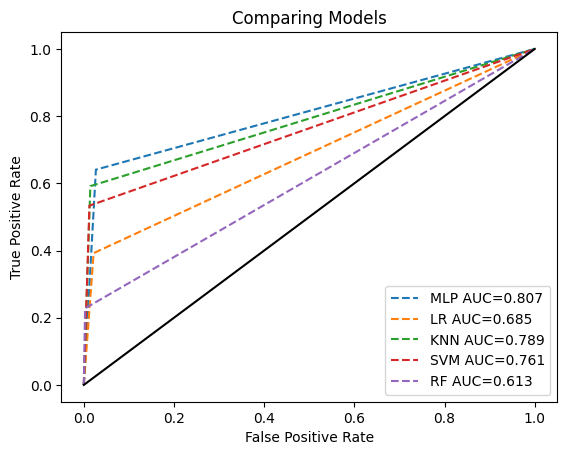

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Calculate AUC for test data
mlp_auc = roc_auc_score(train_y, mlp_class)
logit_auc = roc_auc_score(train_y, logit_class)
knn_auc = roc_auc_score(train_y, knn_class)
svm_auc = roc_auc_score(train_y, svm_class)
rf_auc = roc_auc_score(train_y, rf_class)

# calculate fpr and tpr for all models
mlp_fpr, mlp_tpr, _ = roc_curve(train_y, mlp_class)
logit_fpr, logit_tpr, _ = roc_curve(train_y, logit_class)
knn_fpr, knn_tpr, _ = roc_curve(train_y, knn_class)
svm_fpr, svm_tpr, _ = roc_curve(train_y, svm_class)
rf_fpr, rf_tpr, _ = roc_curve(train_y, rf_class)

# Plotting
plt.plot(mlp_fpr, mlp_tpr, linestyle='--', label="{}{:.3f}".format("MLP AUC=", mlp_auc))
plt.plot(logit_fpr, logit_tpr, linestyle='--', label="{}{:.3f}".format("LR AUC=", logit_auc))
plt.plot(knn_fpr, knn_tpr, linestyle='--', label="{}{:.3f}".format("KNN AUC=", knn_auc))
plt.plot(svm_fpr, svm_tpr, linestyle='--', label="{}{:.3f}".format("SVM AUC=", svm_auc))
plt.plot(rf_fpr, rf_tpr, linestyle='--', label="{}{:.3f}".format("RF AUC=", rf_auc))
plt.plot([0, 1], [0, 1], linestyle='solid', c='k')

plt.title("Comparing Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.show()

In [ ]:
#!pip install colorama
from colorama import Fore
print("\n*********************** MODEL DIAGNOSTICS ***********************")
print(Fore.RED + "                                    Accuracy           AUC Score")
print(Fore.BLUE +"Artifical Neural Network (ANN/MLP):", mlp_accuracy, mlp_auc)
print("Logistic Regression (LR):          ", logit_accuracy, logit_auc)
print("K-Nearest Neighbor Regression(KNN):", knn_accuracy, knn_auc)
print("Support Vector Model (SVM):        ", svm_accuracy, svm_auc)
print("Random Forest Model (RF):          ", rf_accuracy, rf_auc)



*********************** MODEL DIAGNOSTICS ***********************
                                    Accuracy           AUC Score
Artifical Neural Network (ANN/MLP): 0.9207110609480813 0.8069727551239941
Logistic Regression (LR):           0.8857223476297968 0.6852676870413731
K-Nearest Neighbor Regression(KNN): 0.9233916478555305 0.7885959345207911
Support Vector Model (SVM):         0.9159142212189616 0.7605573389231315
Random Forest Model (RF):           0.8758465011286681 0.6126007607670911


After analyzing our model diagnostics the KNN Model appears to have the highest accuracy score, however ANN/MLP has a higher AUC Score. Therefore, we conclude that the ANN/MLP model is superior when taking both score into account.

In [ ]:
from sklearn.model_selection import learning_curve

size, train_scores, test_scores = learning_curve(estimator=mlp, X=train_X, y=train_y,
                                                 train_sizes=np.linspace(0.1, 1, 10),
                                                 cv=5, n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(size, train_mean, color='r', marker='o', label='Training Accuracy')
plt.plot(size, test_mean, color='b', marker='o', label='Testing Accuracy')
plt.xlabel('Training Sample', fontsize=15)
plt.ylabel('5FCV - Mean Accuracy', fontsize=15)
plt.legend(loc='lower right', fontsize=10)
plt.grid()
plt.show()

KeyboardInterrupt: 

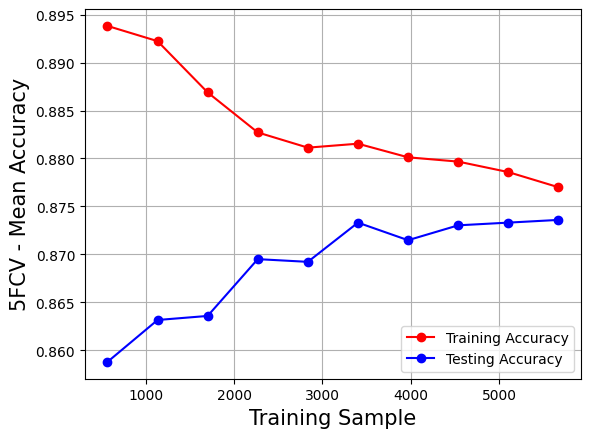

In [ ]:
from sklearn.model_selection import learning_curve

size, train_scores, test_scores = learning_curve(estimator=rf, X=train_X, y=train_y,
                                                 train_sizes=np.linspace(0.1, 1, 10),
                                                 cv=5, n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(size, train_mean, color='r', marker='o', label='Training Accuracy')
plt.plot(size, test_mean, color='b', marker='o', label='Testing Accuracy')
plt.xlabel('Training Sample', fontsize=15)
plt.ylabel('5FCV - Mean Accuracy', fontsize=15)
plt.legend(loc='lower right', fontsize=10)
plt.grid()
plt.show()

After analyzing both models' learning curves we can see that random forest's training accuracy diminishes with a greater sample size. This may be due to certain characteristics in the sample that may throw off the model. Conversely, the ANN training accuracy remains higher even with a larger sample size.